In [85]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [86]:
# File paths
train_features_path = r'C:\Users\utsav\Downloads\dataset and all\training_set_features.csv'
train_labels_path = r'C:\Users\utsav\Downloads\dataset and all\training_set_labels.csv'
test_features_path = r'C:\Users\utsav\Downloads\dataset and all\test_set_features.csv'
submission_format_path = r'C:\Users\utsav\Downloads\dataset and all\submission_format.csv'

# Load the datasets
train_features = pd.read_csv(train_features_path)
train_labels = pd.read_csv(train_labels_path)
test_features = pd.read_csv(test_features_path)
submission_format = pd.read_csv(submission_format_path)

In [87]:
# Merge train features and labels
train_data = pd.merge(train_features, train_labels, on='respondent_id')

In [88]:
# Fill missing values in both train and test datasets
train_data.fillna(method='ffill', inplace=True)
test_features.fillna(method='ffill', inplace=True)

In [89]:
# Exploratory Data Analysis (EDA)
print("Columns in training data:", train_data.columns)

Columns in training data: Index(['respondent_id', 'xyz_concern', 'xyz_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_xyz', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_xyz_vacc_effective', 'opinion_xyz_risk',
       'opinion_xyz_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'xyz_vaccine', 'seasonal_vaccine'],
      dtype='object')


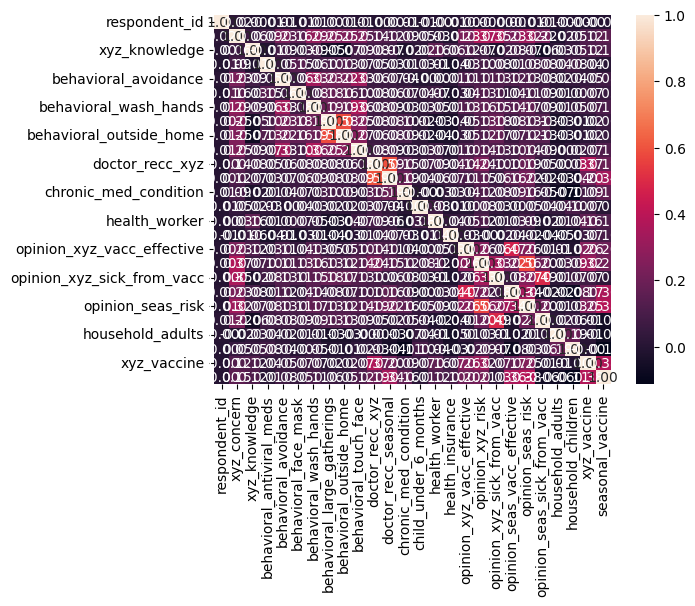

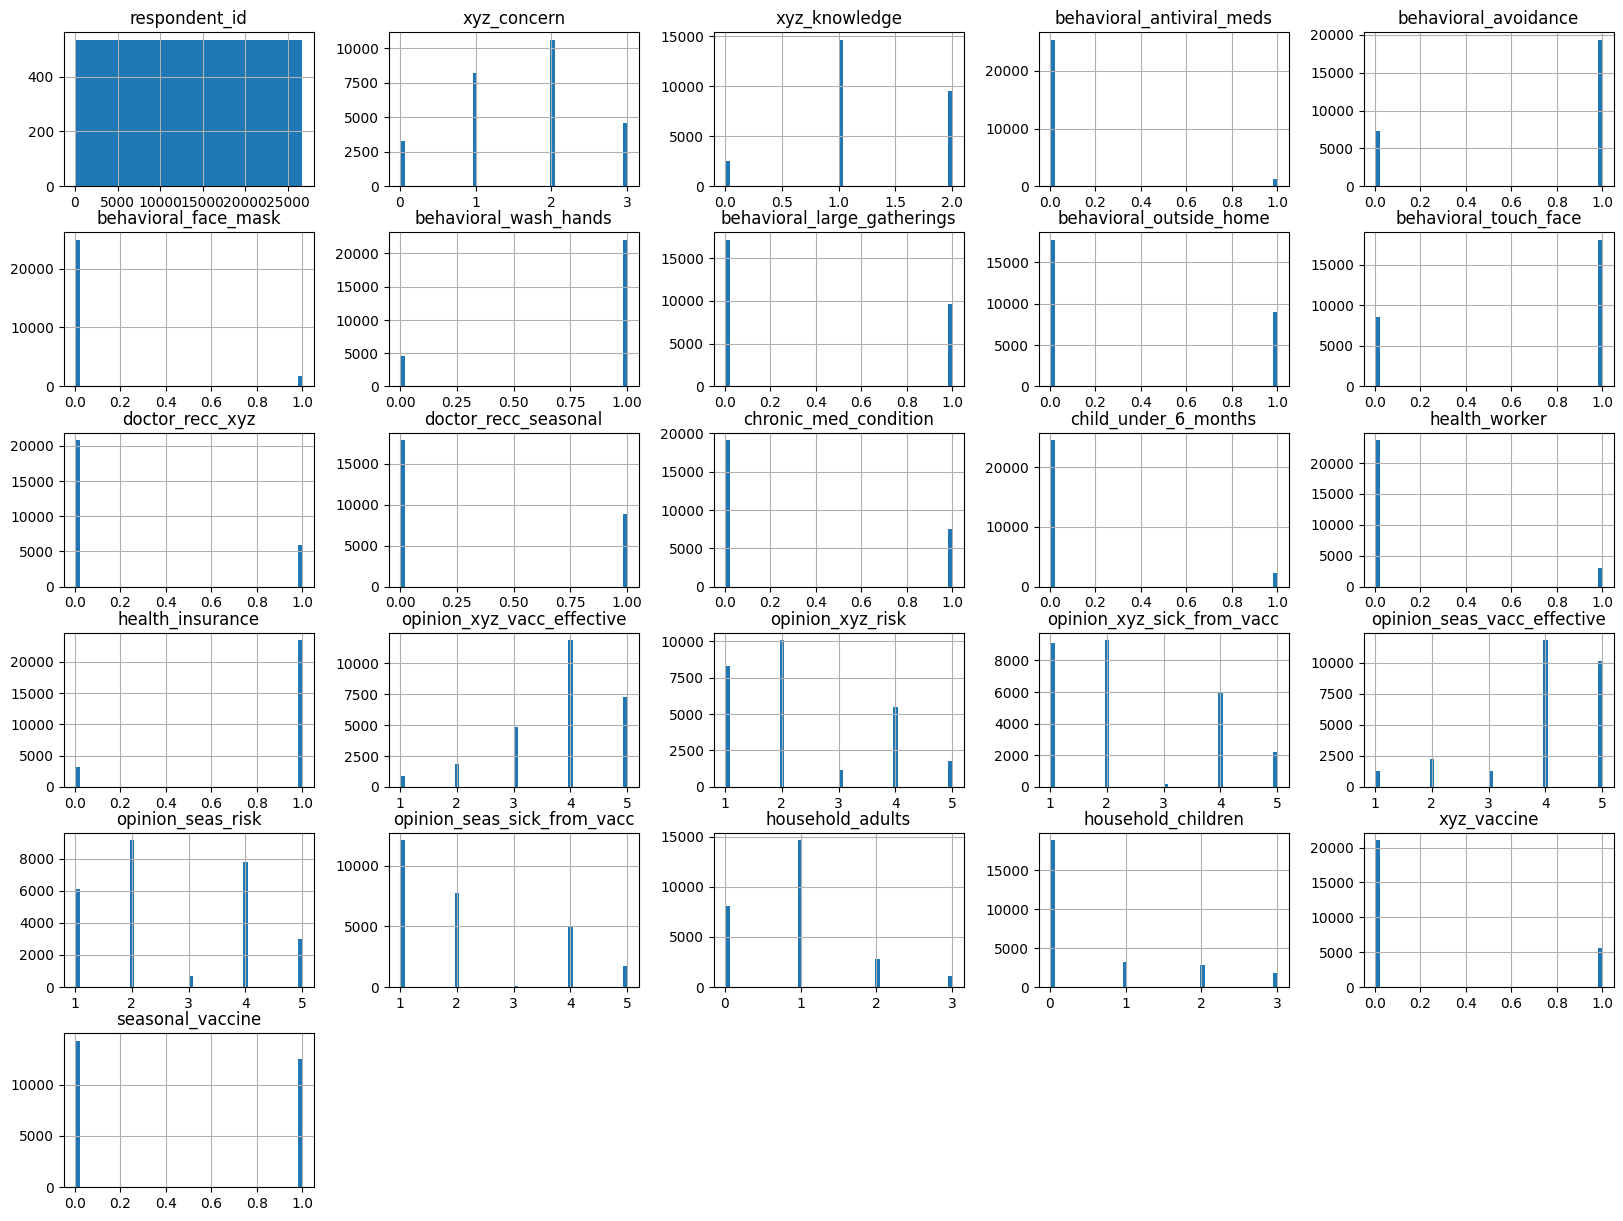

In [90]:
# Select only numeric columns for the correlation matrix
numeric_columns = train_data.select_dtypes(include=[np.number]).columns
corr_matrix = train_data[numeric_columns].corr()

# Plotting the correlation matrix
sns.heatmap(corr_matrix, annot=True, fmt='.2f')
plt.show()

# Plotting histograms of numeric features
train_data[numeric_columns].hist(bins=50, figsize=(20, 15))
plt.show()

In [91]:
# Label encoding non-numeric features
label_encoders = {}
for column in train_data.select_dtypes(include=[object]).columns:
    if column not in ['xyz_vaccine', 'seasonal_vaccine']:
        le = LabelEncoder()
        train_data[column] = le.fit_transform(train_data[column])
        label_encoders[column] = le

In [92]:
# Apply the same label encoding to the test dataset
for column, le in label_encoders.items():
    if column in test_features.columns:
        test_features[column] = le.transform(test_features[column])

In [93]:
# Feature Engineering: Adding new features to both train and test datasets
# Note: Adjust column names based on actual features in your dataset
train_data['new_feature'] = train_data[numeric_columns[0]] * train_data[numeric_columns[1]]
test_features['new_feature'] = test_features[numeric_columns[0]] * test_features[numeric_columns[1]]

In [94]:
# Separating features and labels for the training data
X = train_data.drop(columns=['respondent_id', 'xyz_vaccine', 'seasonal_vaccine'])
y_xyz = train_data['xyz_vaccine']
y_seasonal = train_data['seasonal_vaccine']

In [95]:
# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_features_scaled = scaler.transform(test_features.drop(columns=['respondent_id']))

In [96]:
# Model Training and Evaluation for xyz_vaccine
# Splitting the data into training and validation sets
X_train_xyz, X_val_xyz, y_train_xyz, y_val_xyz = train_test_split(X_scaled, y_xyz, test_size=0.2, random_state=42)

In [97]:
# Training the RandomForest model for xyz_vaccine
model_xyz = RandomForestClassifier(n_estimators=100, random_state=42)
model_xyz.fit(X_train_xyz, y_train_xyz)

RandomForestClassifier(random_state=42)

In [98]:
# Evaluating the model for xyz_vaccine
y_pred_xyz_proba = model_xyz.predict_proba(X_val_xyz)[:, 1]
roc_auc_xyz = roc_auc_score(y_val_xyz, y_pred_xyz_proba)
print("ROC AUC for xyz_vaccine:", roc_auc_xyz)

ROC AUC for xyz_vaccine: 0.8282312860852683


In [99]:
# Model Training and Evaluation for seasonal_vaccine
# Splitting the data into training and validation sets
X_train_seasonal, X_val_seasonal, y_train_seasonal, y_val_seasonal = train_test_split(X_scaled, y_seasonal, test_size=0.2, random_state=42)

In [100]:
# Training the RandomForest model for seasonal_vaccine
model_seasonal = RandomForestClassifier(n_estimators=100, random_state=42)
model_seasonal.fit(X_train_seasonal, y_train_seasonal)

RandomForestClassifier(random_state=42)

In [101]:
# Evaluating the model for seasonal_vaccine
y_pred_seasonal_proba = model_seasonal.predict_proba(X_val_seasonal)[:, 1]
roc_auc_seasonal = roc_auc_score(y_val_seasonal, y_pred_seasonal_proba)
print("ROC AUC for seasonal_vaccine:", roc_auc_seasonal)

ROC AUC for seasonal_vaccine: 0.8461842426325965


In [102]:
# Making predictions on the test set
test_predictions_xyz_proba = model_xyz.predict_proba(test_features_scaled)[:, 1]
test_predictions_seasonal_proba = model_seasonal.predict_proba(test_features_scaled)[:, 1]

In [103]:
# Preparing the submission file
submission_format['xyz_vaccine'] = test_predictions_xyz_proba
submission_format['seasonal_vaccine'] = test_predictions_seasonal_proba

In [105]:
# Saving the final submission file
submission_format.to_csv('submission.csv', index=False)
print("Submission file saved as submission.csv")

Submission file saved as submission.csv
